2019년 KBO 타자 OPS 예측
======================

## 1. Data Cleansing and Crawling

### 모듈

In [1]:
# matplotlib 한글 출력 가능하도록 만들기
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [2]:
# 데이터 크롤링 모듈
from selenium import webdriver
from bs4 import BeautifulSoup
import re

In [3]:
# 데이터 분석 모듈
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime

### 파일

In [4]:
submission = pd.read_csv("data/submission.csv")
reg = pd.read_csv("data/Regular_Season_Batter.csv")

### STATIZ 크롤링

In [5]:
# 가상 웹드라이버 불러오기
# chromedriver.exe가 크롬 버젼에 맞게 설치 되어 있어야 함
driver = webdriver.Chrome('webdrivers/chromedriver.exe')

In [6]:
# 크롤링
for i in range(86):
    
    # 1982년 부터 2018년 까지 statiz에 기록된 선수들 필터링 (총 8558명)
    url = 'http://www.statiz.co.kr/stat.php?mid=stat&re=0&ys=1982&ye=2018&sn=100&pa={}'.format(i*100)
    
    driver.get(url)
    driver.implicitly_wait(5)
    
    html = driver.find_element_by_xpath('//*[@id="mytable"]/tbody').get_attribute("innerHTML") #기록 table을 str형태로 저장
    soup = BeautifulSoup(html, 'html.parser') #str 객체를 BeautifulSoup 객체로 변경
    
    temp = [i.text.strip() for i in soup.findAll("tr")] #tr 태그에서, text만 저장하기
    temp = pd.Series(temp) #list 객체에서 series 객체로 변경
    
    #'순'이나 'W'로 시작하는 row 제거
    # 즉, 선수별 기록만 남기고, index를 reset 해주기
    temp = temp[~temp.str.match("[순W]")].reset_index(drop=True) 
    
    temp = temp.apply(lambda x: pd.Series(x.split(' '))) #띄어쓰기 기준으로 나눠서 dataframe으로 변경
    
    #선수 팀 정보 이후 첫번째 기록과는 space 하나로 구분, 그 이후로는 space 두개로 구분이 되어 있음 
    #그래서 space 하나로 구분을 시키면, 빈 column들이 존재 하는데, 해당 column들 제거 
    temp = temp.replace('', np.nan).dropna(axis=1) 
    
    #WAR 정보가 들어간 column이 2개 있다. (index가 1인 column과, 제일 마지막 column)
    #그 중에서 index가 1인 columm 제거 
    temp = temp.drop(1, axis=1)
    
    #선수 이름 앞의 숫자 제거
    temp[0] = temp[0].str.replace("^\d+", '')

    # 선수들의 생일 정보가 담긴 tag들 가지고 오기
    birth = [i.find("a") for i in soup.findAll('tr') if 'birth' in i.find('a').attrs['href']]
    
    # tag내에서, 생일 날짜만 추출하기 
    p = re.compile("\d{4}\-\d{2}\-\d{2}")
    birth = [p.findall(i.attrs['href'])[0] for i in birth]
    
    # 생일 column 추가
    temp['생일'] = birth
    
    # page별 완성된 dataframe을 계속해서 result에 추가 시켜주기 
    if i == 0:
        result = temp
    else:
        result = result.append(temp)
        result = result.reset_index(drop=True)
        
    print(i, "완료")
        
#column 명 정보 저장        
columns = ['선수'] + [i.text for i in soup.findAll("tr")[0].findAll("th")][4:-3] + ['타율', '출루', '장타', 'OPS', 'wOBA', 'wRC+', 'WAR+', '생일']

#column 명 추가
result.columns = columns

#webdriver 종료
driver.close()

print("최종 완료")

0 완료
1 완료
2 완료
3 완료
4 완료
5 완료
6 완료
7 완료
8 완료
9 완료
10 완료
11 완료
12 완료
13 완료
14 완료
15 완료
16 완료
17 완료
18 완료
19 완료
20 완료
21 완료
22 완료
23 완료
24 완료
25 완료
26 완료
27 완료
28 완료
29 완료
30 완료
31 완료
32 완료
33 완료
34 완료
35 완료
36 완료
37 완료
38 완료
39 완료
40 완료


c:\users\user pc\appdata\local\programs\python\python37-32\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


41 완료
42 완료
43 완료
44 완료
45 완료
46 완료
47 완료
48 완료
49 완료
50 완료
51 완료
52 완료
53 완료
54 완료
55 완료
56 완료
57 완료
58 완료
59 완료
60 완료
61 완료
62 완료
63 완료
64 완료
65 완료
66 완료
67 완료
68 완료
69 완료
70 완료
71 완료
72 완료
73 완료
74 완료
75 완료
76 완료
77 완료
78 완료
79 완료
80 완료
81 완료
82 완료
83 완료
84 완료
85 완료
최종 완료


In [8]:
result.shape

(8558, 28)

In [9]:
#결과값 저장해두기
result.to_csv("data/statiz_origin.csv")

## 데이터 전처리

### 선수정보

In [31]:
# 저장해둔 데이터 불러오기
# result = pd.read_csv("data/statiz_origin.csv", index_col=0)

In [10]:
# 이름 분리 해서, '이름' column 추가
result['이름'] = result['선수'].str.findall("^[ㄱ-힣]+").apply(lambda x: x[0])

# 기존 '선수' column 에 있던 이름 정보 제거
result['선수'] = result.apply(lambda x: x['선수'].replace(x['이름'], ''), axis=1)

In [11]:
# '시즌' column 생성
result['시즌'] = result['선수'].apply(lambda x: x[:2])

# 기존 '선수' column 에 있던 시즌 정보 제거
result['선수'] = result.apply(lambda x: x['선수'].replace(x['시즌'],''), axis=1)

# 년도를 4자리 숫자로 바꾸어주기 ex) 98 -> 1998, 15 -> 2015
result['시즌'] = result['시즌'].apply(lambda x: int("20"+ x) if int(x) < 30 else int("19"+x))

In [12]:
# 포지션
position = ['1B', '2B', '3B', 'SS', 'C', 'RF', 'LF', 'CF', 'DH'] 

# 포지션 여부 확인
result['포지션여부'] = result['선수'].apply(lambda x : (np.isin(x[-2:], position) or np.isin(x[-1:], position))) 

# 포지션 분리
result['포지션'] = result['선수'].apply(lambda x: x[-2:] if x[-2:] in position else x[-1:])

#포지션이 기록 되어 있지 않으면, nan값 넣기 
result.loc[result['포지션여부']==False, '포지션'] = np.nan

In [13]:
#statiz 사이트에, 2015시즌 조홍석 데이터에 생일이 기록 안되어 있음, 해당 시즌의 생일 추가 
result.loc[(result.이름 =='조홍석'),'생일']

3475    1990-02-23
6466    0000-00-00
6855    1990-02-23
7874    1990-02-23
Name: 생일, dtype: object

In [14]:
result.loc[(result.이름 =='조홍석')&(result.시즌 ==2015),'생일'] = '1990-02-23'

In [15]:
result[(result.이름 =='조홍석')&(result.시즌 ==2015)].생일

6466    1990-02-23
Name: 생일, dtype: object

In [16]:
# 팀 & 나이 column 생성
result['팀'] = result.apply(lambda x: x['선수'].replace(x['포지션'],'') if type(x['포지션'])==str else x['선수'], axis=1)
result['나이'] = result.apply(lambda x: x['시즌'] - int(x['생일'][:4]) + 1, axis=1)

In [17]:
# 선수별 고유 아이디 부여
info = result[['이름', '생일']].apply(lambda x: tuple(x), axis=1)

player_id = {}
for i,j in enumerate(info.unique()):
    player_id[j] = i
    
result['ID'] = result.apply(lambda x: player_id[tuple([x['이름'], x['생일']])], axis=1)

In [18]:
# submission에는 있지만, statiz에는 없는 이름 확인
# 선수가 이름을 개명하여 submission과 statiz에 다르게 기록됨
# statiz가 홈페이지를 업데이트를 할 때마다, 그리고 선수들이 개명을 할 때마다 다른 값이 나오므로,
# 해당 코드를 돌릴 때마다 이름이 다르게 나올 수 있음 
# 윤여운 -> 윤수강 (submission : 윤수강 / statiz : 윤여운)
# 이유찬 -> 이병휘 (submission : 이병휘 / statiz : 이유찬)
submission[~np.isin(submission['batter_name'], result['이름'])]

,batter_id,batter_name,batter_ops
129,195,윤수강,0
138,208,이병휘,0


In [19]:
# 이름 변경
result['이름'] = result['이름'].replace("윤여운", "윤수강").replace('이유찬', '이병휘')

In [20]:
# numeric data로 변환
float_columns = result.iloc[:,1:27].columns
result[float_columns] = result[float_columns].astype(float).fillna(0)

In [21]:
# 필요한 features 선택
cols = ['ID', '이름', '생일', '팀', '시즌', '포지션', '나이'] + list(float_columns)
result = result[cols]

## 2. Visualization

In [22]:
print("<전체 column 타입확인>\n\n",result.dtypes.value_counts())
print()
print("<object type columns>\n\n",result.columns[result.dtypes=='object'])

<전체 column 타입확인>

 float64    26
object      4
int64       3
dtype: int64

<object type columns>

 Index(['이름', '생일', '팀', '포지션'], dtype='object')


In [23]:
# Find correlations with the target and sort
correlations = result.corr()['OPS'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(11))
print('\nMost Negative Correlations:\n', correlations.head(10))

Most Positive Correlations:
 타수      0.605591
안타      0.607215
타석      0.607968
루타      0.609306
G       0.629138
wRC+    0.840125
출루      0.901480
wOBA    0.951055
타율      0.967631
장타      0.982626
OPS     1.000000
Name: OPS, dtype: float64

Most Negative Correlations:
 ID   -0.584864
시즌   -0.090651
나이    0.172608
희타    0.283392
도루    0.318953
고4    0.343591
3타    0.353408
도실    0.380572
사구    0.452578
희비    0.466994
Name: OPS, dtype: float64


#### OPS와 높은 상관관계
- 장타, 타율, wOBA, 출루, wRC+, G,루타, 타석,안타

#### OPS와 낮은 상관관계
- 나이, 희타, 도루, 고4, 3타, 도실, 사구, 희비

Text(0.5, 1.0, 'Top 10 correlations with OPS')

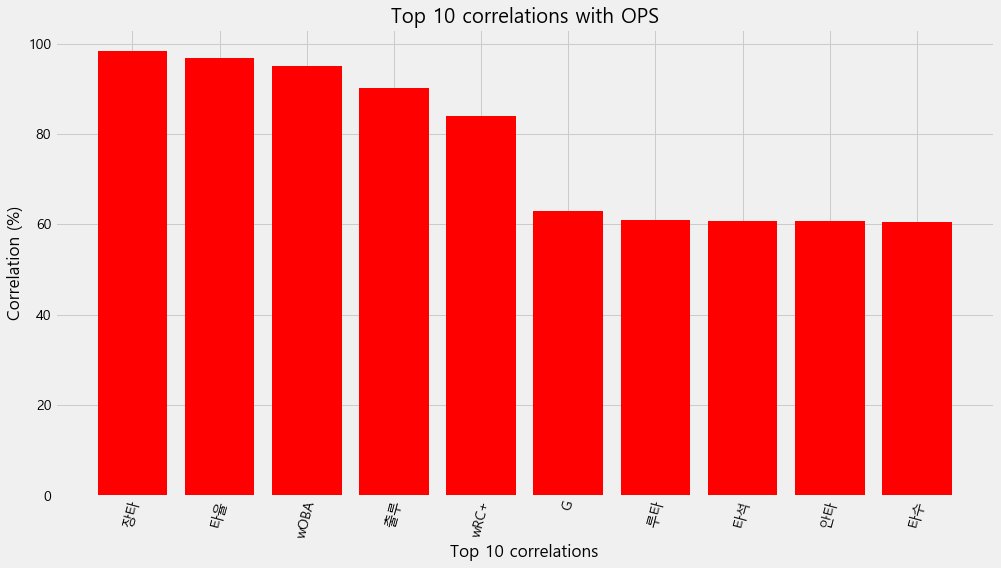

In [24]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15,8))

plt.bar(correlations.tail(11)[:-1].index.astype(str)[::-1], 100*correlations.tail(11)[:-1][::-1],color='r')

# Plot labeling
plt.xticks(rotation=75) ; plt.xlabel('Top 10 correlations'); plt.ylabel('Correlation (%)');
plt.title('Top 10 correlations with OPS')

Text(0.5, 1.0, 'Low 8 correlations with OPS')

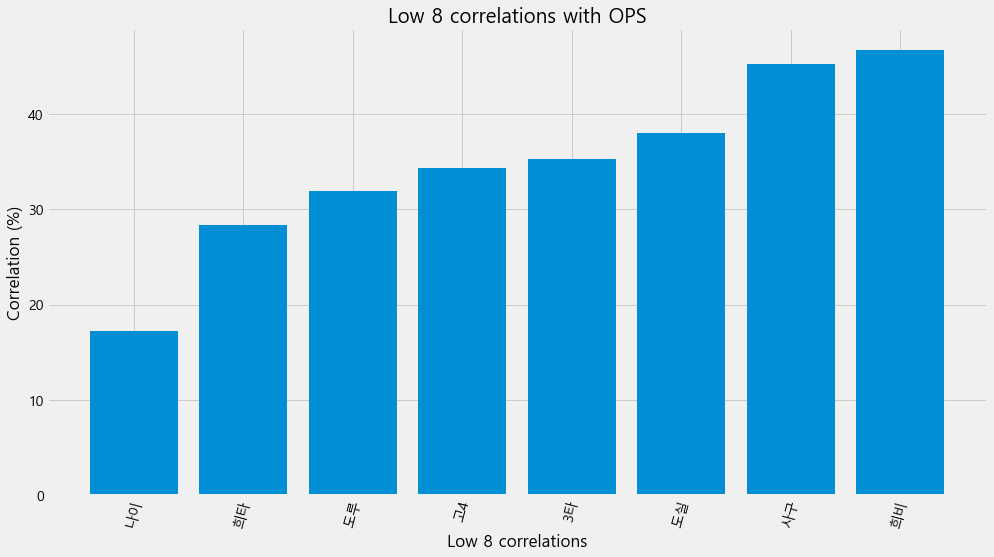

In [25]:
plt.figure(figsize=(15,8))

plt.bar(correlations.head(10)[2:].index.astype(str), 100*correlations.head(10)[2:])

# Plot labeling
plt.xticks(rotation=75) ; plt.xlabel('Low 8 correlations'); plt.ylabel('Correlation (%)')
plt.title('Low 8 correlations with OPS')

Top 5. High correlation with 'OPS' Pair Plot


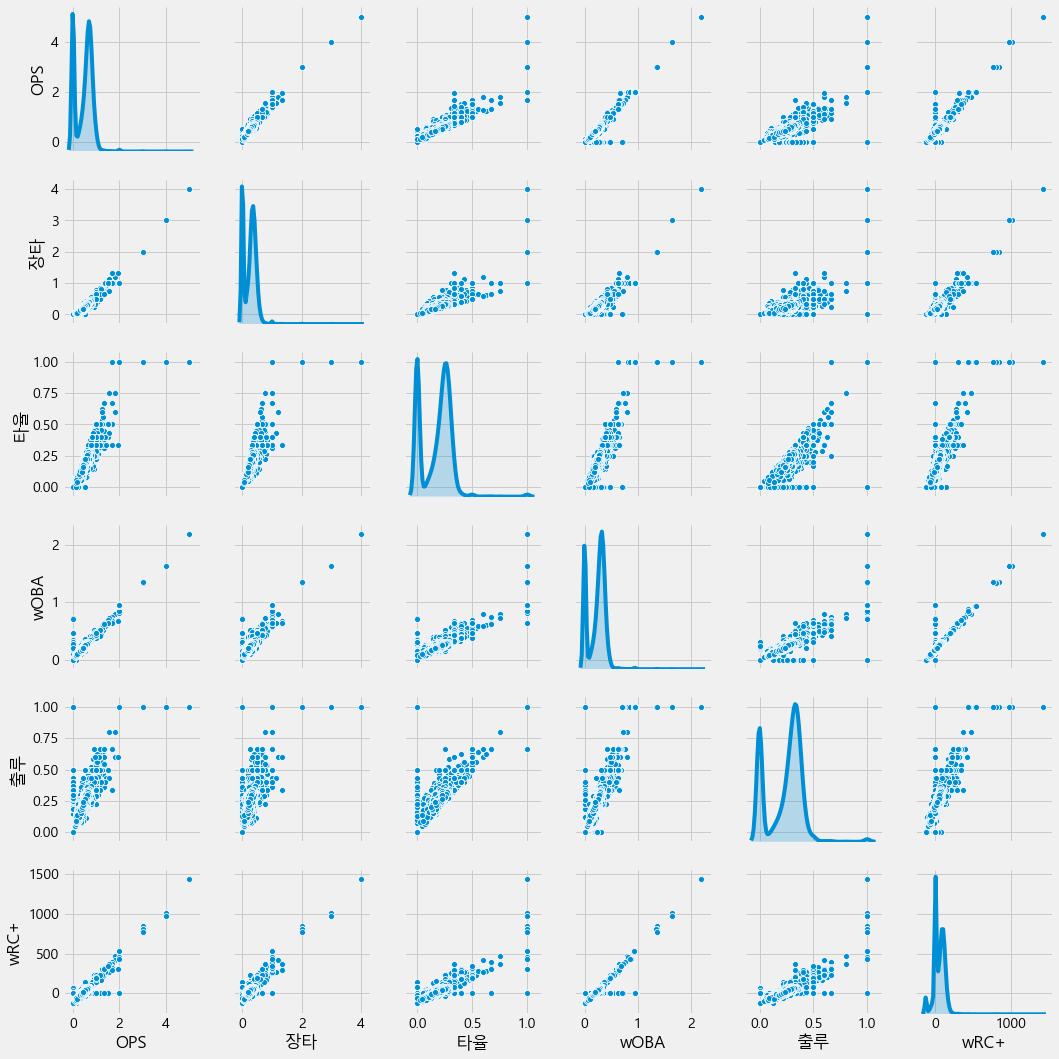

In [26]:
#Top 5. High correlation with 'OPS' Pair Plot
print("Top 5. High correlation with 'OPS' Pair Plot")
high_corr = result.loc[:,list(correlations.tail(6)[::-1].index)]
sns.pairplot(high_corr,diag_kind='kde')
plt.show()

- OPS와 선형성을 보이는 변수들이 있음

Top5. Low correlation with 'OPS' Pair Plot


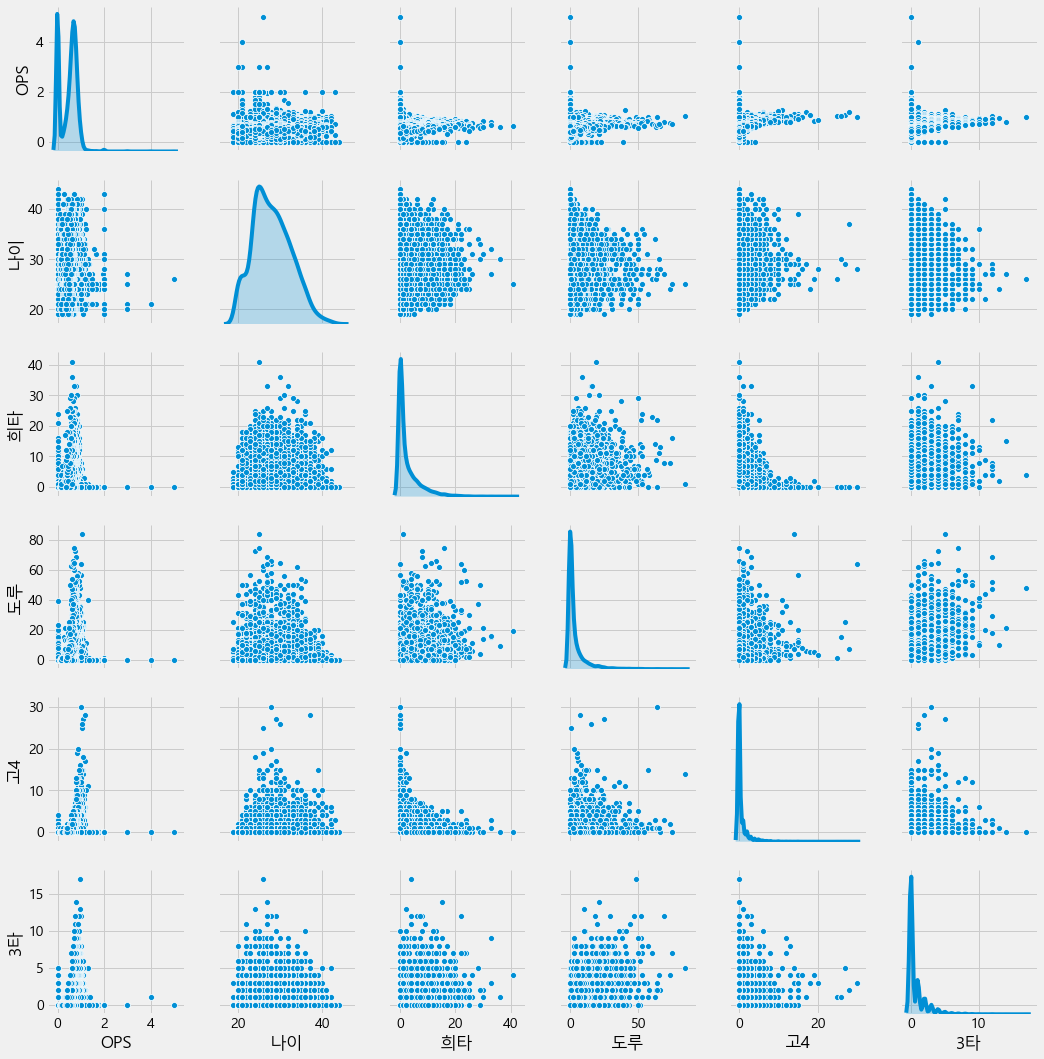

In [27]:
# Top5. Low correlation with 'OPS' Pair Plot
print("Top5. Low correlation with 'OPS' Pair Plot")
low_corr = result.loc[:,['OPS']+list(correlations.head(7)[2:].index)]
sns.pairplot(low_corr,diag_kind='kde')
plt.show()

- OPS의 분포는 좁은 것에 비해서 상관성이 낮은 변수들은 분포가 넓음 (OPS 예측에 큰 도움이 안됨)

In [28]:
# dtype이 object인 것과 OPS 추출
result_obj=result.loc[:,list(result.columns[result.dtypes=='object'])+['OPS']]

c:\users\user pc\appdata\local\programs\python\python37-32\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, '포지션별 OPS violinplot')

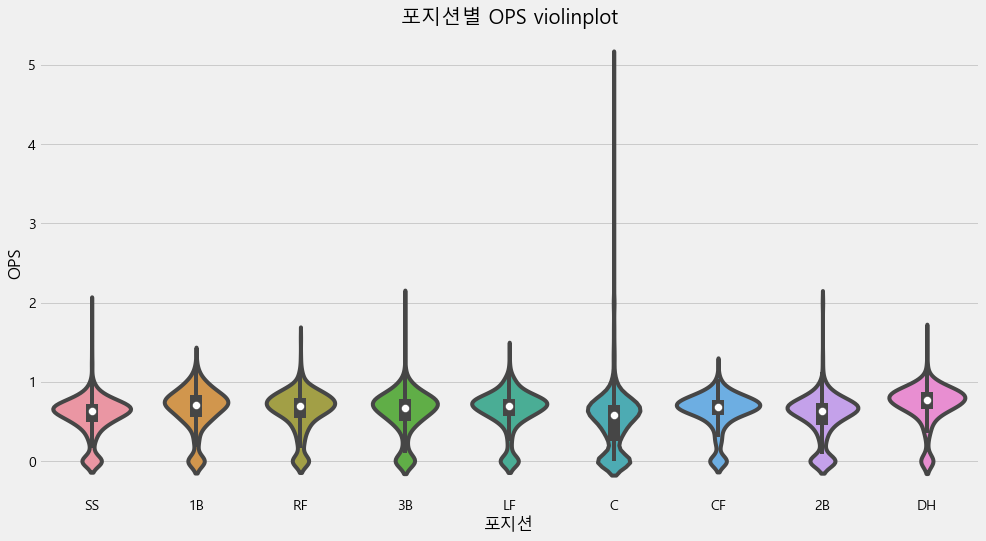

In [29]:
# 포지션별 OPS violinplot 그려보기
plt.figure(figsize=(15,8))
sns.violinplot(x='포지션',y='OPS',data=result_obj)
plt.title("포지션별 OPS violinplot")

- violinplot: Box plot(분위수 확인)과 KDE plot(데이터의 분포 확인)을 동시에 할 수 있다
- C (포수) 포지션의 경우 다른 포지션에 비해서 outlier가 매우 큰 선수가 있는 것으로 보인다.

## 3. Feature Engineering

In [30]:
# 1루타 feature 생성
result['1타'] = result['안타'] - result['2타'] - result['3타'] - result['홈런']

In [31]:
# 사용 features 명시
infos = ['ID','이름','생일','팀','시즌','포지션','나이']
stats = ['G','타수','득점','안타','1타','2타','3타','홈런','루타','타점','도루','도실','볼넷','사구','고4','삼진'\
        ,'병살','희타','희비','타율','출루','장타','OPS','wOBA','wRC+','WAR+']

In [32]:
# 해당 시즌 이전까지의 누적 기록
def get_cumulative(player_id, season, stat=stats ,df=result):
    try:
        result_cum = df[(df['ID']==player_id) & (df['시즌'] < season)][stat]
        result_cum = result_cum.mean()
        
    except:
        result_cum = [np.nan for i in stat]
        result_cum = pd.Series(result_cum)
    
    return result_cum

In [33]:
# 모든 stats에 대한 누적 stat
stats_cum = [i + '_누적' for i in stats]

In [34]:
# 누적 stat 데이터프레임에 반영
result[stats_cum] = result.apply(lambda x: get_cumulative(x['ID'], x['시즌']), axis=1)

In [35]:
# lag stat (직전 몇년의 기록)
def get_lag(player_id, season, lag, stat=stats, df=result):
    try:
        result_lag = df[(df['ID']==player_id)&(df['시즌'] == season-lag)][stat].values[0]
        result_lag = pd.Series(result_lag)
        
    except:
        result_lag = [np.nan for i in stat]
        result_lag = pd.Series(result_lag)
        
    return result_lag

In [36]:
# 직전 1,2,3년의 기록
stats_lag1 = [i + '_LAG1' for i in stats]
stats_lag2 = [i + '_LAG2' for i in stats]
stats_lag3 = [i + '_LAG3' for i in stats]

In [37]:
# lag1
result[stats_lag1] = result.apply(lambda x: get_lag(x['ID'],x['시즌'], lag=1), axis=1)

In [38]:
# lag2
result[stats_lag2] = result.apply(lambda x: get_lag(x['ID'],x['시즌'], lag=2), axis=1)

In [39]:
# lag3
result[stats_lag3] = result.apply(lambda x: get_lag(x['ID'],x['시즌'], lag=3), axis=1)

In [40]:
# 내년 기록 (OPS, 장타, 출루)
# 데이터 프레임의 정답 셋 만들기 위함

def get_next_year(player_id, season, stat=['장타','출루','OPS'],df=result):
    try:
        result = df[(df['ID']==player_id)&(df['시즌']==season+1)][stat].values[0]
        result = pd.Series(result)
    except:
        result = [np.nan for i in stat]
        result = pd.Series(result)
        
    return result

In [41]:
# 장타, 출루, OPS의 내년 기록
stats_next = [i + '_NEXT' for i in ['장타', '출루', 'OPS']]
result[stats_next] = result.apply(lambda x: get_next_year(x['ID'], x['시즌']), axis=1)

In [ ]:
# 변환 데이터 저장
# result.to_csv("data/statiz_v2.csv")

## 4. Model Building

## 모델링

In [42]:
# 출력 할 때 마다, 기존 출력물들은 제거해주는 모듈
from IPython.display import clear_output

In [43]:
# 모델 모듈
from xgboost import XGBRegressor, plot_importance
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [44]:
df = result.fillna(-1) # nan값 -1로 impute 
df = df[df['OPS_NEXT'] > 0] # 다음 해의 OPS가 존재하는 값들만 추출 (다음 해 OPS 가 없다면, predict 값과 target값을 비교 할 수 없기 때문)

In [45]:
df = pd.concat([df, pd.get_dummies(df['포지션'], drop_first=True)], axis=1) # 포지션 dummy variable로 변환

### 학습

In [46]:
# 사용 features 명시
infos = ['ID','이름','생일','팀','시즌','포지션','나이']
stats = ['G','타수','득점','안타','1타','2타','3타','홈런','루타','타점','도루','도실','볼넷','사구','고4','삼진'\
        ,'병살','희타','희비','타율','출루','장타','OPS']

In [47]:
# 누적 및 lag stat features 이름
stats_cum = [i + '_누적' for i in stats]
stats_lag1 = [i + '_LAG1' for i in stats]
stats_lag2 = [i + '_LAG2' for i in stats]
stats_lag3 = [i + '_LAG3' for i in stats]

In [48]:
# X features와 y feature 정리
stats_position = ['2B', '3B', 'C', 'CF', 'DH', 'LF', 'RF', 'SS']
X_cols = stats + stats_cum + stats_lag1 + stats_lag2 + stats_position + ['나이']
y_cols = ['OPS_NEXT']

In [49]:
# 학습시킬 모델
model_dict = {'xgb':XGBRegressor(n_estimators=110, learning_rate=0.05 ,max_depth=3, min_samples_split=400, random_state=23),
              'lgbm':LGBMRegressor(),
              'rf':RandomForestRegressor(),
              'svr':SVR(),
              'knn':KNeighborsRegressor(),
              'reg':LinearRegression(),
              'ridge':Ridge(),
              'lasso':Lasso()}

In [50]:
# 2009 ~ 2016년 기간의 데이터로 검증
# 예를들어 2010년은 2009년까지의 데이터로, 2011년은 2010년까지의 데이터로 검증
# 에러가 가장 낮은 두 모델, xgboost와 ridge 중 ridge 선택
# ridge가 xgboost에 비해 과적합이 적고 일반화가 더 잘 이뤄졌을 것이라는 판단

test_error = []
r2 = []

for year in range(2010, 2018):

    train = df[df['시즌'] < year-1].reset_index(drop=True)
    test = df[df['시즌'] == year-1].reset_index(drop=True)
    
    X_train = train[X_cols]
    y_train = train[y_cols]

    X_test = test[X_cols]
    y_test = test[y_cols]
    
    model = model_dict['ridge']    #모델명 바꾸어 가면서 실험 가능
    weight = train['타수']
    model.fit(X_train, y_train, sample_weight=weight)
    y_predict = model.predict(X_test)
    
    test_error.append(mean_squared_error(y_test, y_predict, sample_weight=X_test['타수']) ** 0.5)
    r2.append(r2_score(y_test, y_predict))
    
    clear_output(wait=True)
    print(year, ": 완료")
    
    
print("test error : ", np.mean(test_error))
print("test std : ", np.std(test_error))
print("r2 : ", np.mean(r2))
print("완료")

2017 : 완료
test error :  0.12297661095675332
test std :  0.017695723649870054
r2 :  0.1972005395338279
완료


In [51]:
# 연도별 테스트 에러
test_error

[0.11965635488780504,
 0.10017133715584686,
 0.1113487547340026,
 0.11995787803170647,
 0.1585607101594155,
 0.12152418699996415,
 0.14271784504461912,
 0.10987582064066678]

(0, 1.5)

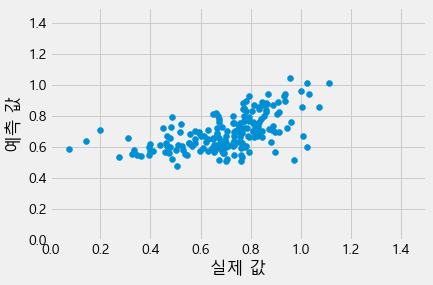

In [52]:
# 예측값과 실제값의 시각화
plt.scatter(y_test, y_predict)
plt.xlabel("실제 값")
plt.ylabel("예측 값")
plt.xlim(0,1.5)
plt.ylim(0,1.5)

## 제출

In [53]:
predict = result[result['시즌']==2018] # 2018년도 데이터 프레임
predict = pd.concat([predict, pd.get_dummies(predict['포지션'], drop_first=True)], axis=1) # 포지션 dummy variable로 변환

In [54]:
# Dacon regular season과 submission 병합
# 추후 statiz data와 병합할 때 기준이 되는 생일 데이터를 얻기 위함
reg_sub = pd.merge(submission, reg[reg['year']==2018], on='batter_id', how='left', suffixes=['','_reg'])

In [55]:
# regular season dataframe의 생일 데이터를 statiz와 일치시킴
reg_sub['year_born'] = reg_sub['year_born'].apply(lambda x: datetime.strptime(x, "%Y년 %m월 %d일").date())
reg_sub['year_born'] = reg_sub['year_born'].astype(str)

In [56]:
# 필요한 feature만 남김
reg_sub = reg_sub[['batter_name', 'year_born', 'batter_id']]

In [57]:
# 이름과 생일을 기준으로 dacon data와 statiz data 병합
total = pd.merge(reg_sub, predict, how='left', left_on=['batter_name', 'year_born'], right_on=['이름', '생일'])

In [58]:
X = total[X_cols] # 사용 feature
X = X.fillna(-1) # NA값 -1로 impute

In [59]:
# 예측
total['y_hat'] = model.predict(X)

In [60]:
# 타자별 예측값 feature에 저장
submission['batter_ops'] = submission['batter_id'].apply(lambda x: total[total['batter_id']==x]['y_hat'].values[0])

In [61]:
# 제출 파일 생성
submission.to_csv("data/tnt_submission.csv", index=False, encoding='utf-8')

In [62]:
# 제출 결과 확인
sub = pd.read_csv('data/tnt_submission.csv')
sub

,batter_id,batter_name,batter_ops
0,1,강경학,0.658489
1,2,강구성,0.546550
2,3,강민국,0.592865
3,4,강민호,0.852663
4,5,강백호,0.894065
5,8,강상원,0.596299
6,9,강승호,0.600272
7,11,강진성,0.595175
8,12,강한울,0.601566
9,16,고명성,0.588540
